In [33]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Lambda
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import os
import gc
from pathlib import Path

from pure_pursuit import *
import tensorflow as tf

import matplotlib.pyplot as plt

In [26]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [30]:
@tf.function
def get_max_dist(track_dists):
    return tf.reduce_max(track_dists, axis=1)

@tf.function
def get_max_dist_idx(track_dists):
    mask = track_dists[:, 9] != 200
    mask = tf.cast(mask, tf.int32)
    indices = tf.math.argmax(track_dists, output_type=tf.int32, axis=1)
    arr1 = indices * mask
    additional = tf.cast(track_dists[:, 9] == 200, tf.int32) * 9
    result = arr1 + additional

    return result

@tf.function
def compute_target_angle(track_dists):
    max_track_dist_idx = self.get_max_dist_idx(track_dists)

    max_dist_angle = max_track_dist_idx * 10 - 90
    return tf.cast(max_dist_angle, tf.float32) * RAD_PER_DEG

@tf.function
def compute_steering(data):

    target_angle = data[:, 1] * RAD_PER_DEG
    lookahead = data[:, 0]

    raw_steering_angle_rad = -tf.math.atan(
        (PURE_PURSUIT_2L * tf.math.sin(target_angle)) / (lookahead + 1e-7))

    raw_steering_angle_deg = raw_steering_angle_rad * DEG_PER_RAD

    normalized_steering_angle = tf.clip_by_value(raw_steering_angle_deg / MAX_STEERING_ANGLE_DEG, -1.0, 1.0)
    return normalized_steering_angle


model = load_model("PI_model_new_2/model.h5", custom_objects={'compute_steering': compute_steering})

In [42]:
[x.output_shape for x in model.layers[3].layers]

[[(None, 65)], (None, 32), (None, 16), (None, 8), (None, 2)]

In [46]:
model.

In [34]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_c (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 model_2 (Functional)           (None, 16)           2640        ['input_c[0][0]']                
                                                                                                  
 dense_c1 (Dense)               (None, 8)            136         ['model_2[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 2)            2794        ['input_c[0][0]']                
                                                                                            

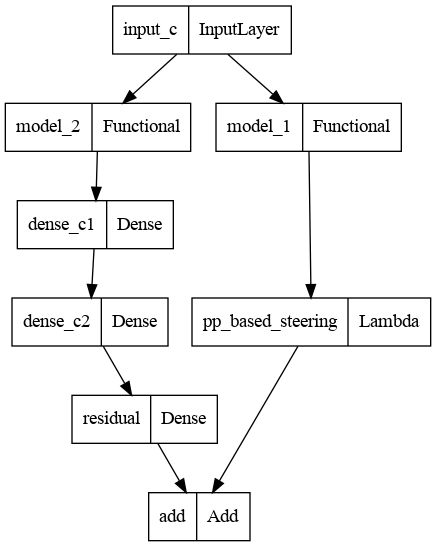

In [35]:
plot_model(model)

In [3]:
MODEL_SAVE_DIR = Path("PI_model_new_test")
if not MODEL_SAVE_DIR.exists():
    os.makedirs(MODEL_SAVE_DIR.as_posix())

### Loading data files

In [4]:
train_files = []
val_files = []

path = Path("../../torcs_SL/data_all/data")
tracks = os.listdir(path.as_posix())

train_tracks = ['g-track-1', 'g-track-2', 'g-track-3', 'g-track-4', 'spring']
test_tracks = ['e-track-3', 'alpine-2', 'corkscrew', 'wheel-2']

random_tracks = np.random.choice(tracks, len(tracks), replace=False)
random_tracks = [x for x in random_tracks if x[:4] != 'dirt' and x[:3] != 'mix' and x not in test_tracks and x not in train_tracks]

val_tracks = random_tracks[:3]
    

track_files = list(path.glob("**/*.csv"))


train_track_files = [x for x in track_files if x.parts[-2] in train_tracks]
val_track_files = [x for x in track_files if x.parts[-2] in val_tracks]
train_track_files, val_track_files

([PosixPath('../../torcs_SL/data_all/data/g-track-2/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-2/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-2/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-1/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-1/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-1/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-3/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-3/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-3/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/spring/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/spring/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/spring/1.csv')],
 [PosixPath('../../torcs_SL/data_all/data/aalborg/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/aalborg/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/aalborg/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/brondehach/2.csv'),
  PosixPath('../../torcs_SL/data_all/

### Train-Test Split

In [ ]:
training_data = pd.DataFrame()
validation_data = pd.DataFrame()
split_ratio = 0.8

for fi in track_files[:int(split_ratio * len(track_files))]:
    training_data = pd.concat([training_data, pd.read_csv(fi)]).reset_index(drop=True)

for fi in track_files[int(split_ratio * len(track_files)):]:
    validation_data = pd.concat([validation_data, pd.read_csv(fi)]).reset_index(drop=True)

In [ ]:
print (training_data.shape)
print (validation_data.shape)

In [ ]:
training_data.columns.values

In [ ]:
del training_data['Gear']
del validation_data['Gear']
del training_data[' CurrentLapTime']
del validation_data[' CurrentLapTime']
del training_data[' LastLapTime']
del validation_data[' LastLapTime']
del training_data[' Damage']
del validation_data[' Damage']
del training_data[' FuelLevel']
del validation_data[' FuelLevel']

del training_data[' DistanceFromStart']
del validation_data[' DistanceFromStart']

for col in [c for c in training_data.columns if c.strip()[:3] == "Opp"]:
    del training_data[col]
    del validation_data[col]

In [ ]:
print (training_data.shape)
print (validation_data.shape)

In [ ]:
training_data.columns

In [ ]:
class PurePursuit:
    
    @staticmethod
    def get_max_dist(track):
        track_dists = np.array(track)
        return np.max(track_dists)
    
    @staticmethod
    def get_max_dist_idx(track):
        track_dists = np.array(track)
        if track_dists[9] == np.max(track_dists) or track_dists[9] == 200:
            return 9
        return np.argmax(track_dists)
    
    @staticmethod
    def compute_target_angle(track):

        max_track_dist_idx = PurePursuit.get_max_dist_idx(track)

        max_dist_angle = max_track_dist_idx * 10. - 90.
        return max_dist_angle 
    
    @staticmethod
    def get_lookahead(track):
        max_track_dist_idx = PurePursuit.get_max_dist_idx(track)
        return track[max_track_dist_idx]

In [ ]:
training_data['target_angle'] = training_data.iloc[:, 8: 27].apply(lambda x : PurePursuit.compute_target_angle(x.values), axis=1)
validation_data['target_angle'] = training_data.iloc[:, 8: 27].apply(lambda x : PurePursuit.compute_target_angle(x.values), axis=1)

training_data['lookahead'] = training_data.iloc[:, 8: 27].apply(lambda x : PurePursuit.get_lookahead(x.values), axis=1)
validation_data['lookahead'] = training_data.iloc[:, 8: 27].apply(lambda x : PurePursuit.get_lookahead(x.values), axis=1)

## PI Model Training

In [ ]:
X_train=training_data.loc[:,[' Track_1',
       'Track_2', 'Track_3', 'Track_4', 'Track_5', 'Track_6', 'Track_7',
       'Track_8', 'Track_9', 'Track_10', 'Track_11', 'Track_12', 'Track_13',
       'Track_14', 'Track_15', 'Track_16', 'Track_17', 'Track_18', 'Track_19', 
        'TrackPosition', 'Angle', ' RPM', ' SpeedX', ' SpeedY', ' SpeedZ',
        ' WheelSpinVelocity_1', 'WheelSpinVelocity_2',
       'WheelSpinVelocity_3', 'WheelSpinVelocity_4', 'target_angle', 'lookahead']]

Y_train=training_data.loc[:,'Steering']
X_val=validation_data.loc[:,[' Track_1',
       'Track_2', 'Track_3', 'Track_4', 'Track_5', 'Track_6', 'Track_7',
       'Track_8', 'Track_9', 'Track_10', 'Track_11', 'Track_12', 'Track_13',
       'Track_14', 'Track_15', 'Track_16', 'Track_17', 'Track_18', 'Track_19', 
        'TrackPosition', 'Angle', ' RPM', ' SpeedX', ' SpeedY', ' SpeedZ',
        ' WheelSpinVelocity_1', 'WheelSpinVelocity_2',
       'WheelSpinVelocity_3', 'WheelSpinVelocity_4', 'target_angle', 'lookahead']]
Y_val=validation_data.loc[:,'Steering']

In [ ]:
print (X_train.shape)
print (Y_train.shape)
print (X_val.shape)
print (Y_val.shape)
scaler = StandardScaler()
X_train.iloc[:, :-2]=scaler.fit_transform(X_train.iloc[:, :-2])
X_val.iloc[:, :-2]=scaler.fit_transform(X_val.iloc[:, :-2])
Y_train=Y_train.values
Y_val=Y_val.values
print (X_train.shape)
print (Y_train.shape)
print (X_val.shape)
print (Y_val.shape)

In [ ]:
np.max(X_train['target_angle'])

### Save these means and stds for test time

In [ ]:
with open(MODEL_SAVE_DIR.joinpath("scaler.pickle").as_posix(), "wb") as fp:
    pickle.dump(scaler, fp)

In [ ]:
scaler.mean_

In [ ]:
scaler.scale_

In [ ]:
np.save(MODEL_SAVE_DIR.joinpath("means.npy"), scaler.mean_)
np.save(MODEL_SAVE_DIR.joinpath("stds.npy"), scaler.scale_)

In [ ]:
@tf.function
def get_max_dist(track_dists):
    return tf.reduce_max(track_dists, axis=1)

@tf.function
def get_max_dist_idx(track_dists):
    mask = track_dists[:, 9] != 200
    mask = tf.cast(mask, tf.int32)
    indices = tf.math.argmax(track_dists, output_type=tf.int32, axis=1)
    arr1 = indices * mask
    additional = tf.cast(track_dists[:, 9] == 200, tf.int32) * 9
    result = arr1 + additional
    
    return result

@tf.function
def compute_target_angle(track_dists):

    max_track_dist_idx = get_max_dist_idx(track_dists)

    max_dist_angle = max_track_dist_idx * 10 - 90
    return tf.cast(max_dist_angle, tf.float32) * RAD_PER_DEG

@tf.function
def compute_target_angle_2(angle_probs):

    max_track_dist_idx = tf.math.argmax(angle_probs, output_type=tf.int32, axis=1)

    max_dist_angle = max_track_dist_idx * 10 - 90
    return tf.cast(max_dist_angle, tf.float32) * RAD_PER_DEG

In [ ]:
@tf.function
def is_off_track(trackPos, angle):
    return tf.abs(trackPos) > 1.0 and tf.abs(angle) > PI_HALF

In [ ]:
@tf.function
def compute_steering(data):

    target_angle = data[:, 1] * RAD_PER_DEG
    lookahead = data[:, 0]


    raw_steering_angle_rad = -tf.math.atan(
        (PURE_PURSUIT_2L * tf.math.sin(target_angle)) / (lookahead + 1e-7))

    raw_steering_angle_deg = raw_steering_angle_rad * DEG_PER_RAD

    normalized_steering_angle = tf.clip_by_value(raw_steering_angle_deg / MAX_STEERING_ANGLE_DEG, -1.0, 1.0)


    return normalized_steering_angle

### Perception Block Warm Start

In [ ]:
learning_rate=1e-3

input_p = Input(shape=(X_train.shape[1]-2,))
l_p = Dense(16, activation="relu",kernel_initializer='he_normal', name='dense_1')(input_p)
l_p = Dense(8, activation="relu",kernel_initializer='he_normal', name='dense_3')(l_p)
#lookahead = Dense(1, activation="relu",kernel_initializer='he_normal', name='lookahead')(l_p)
output = Dense(2,kernel_initializer='he_normal', name='lookahead')(l_p)

model_perception = tf.keras.Model(input_p, output)

model_perception.compile(optimizer=Adam(learning_rate),loss='mean_absolute_error',metrics=['mae'],
             loss_weights=[1, 0])
model_perception.summary()

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_delta=0.0001, min_lr=0)
stats = model_perception.fit(X_train.iloc[:,:-2],X_train.iloc[:,-2:],validation_data=(X_val.iloc[:,:-2],X_val.iloc[:,-2:]),batch_size=512,epochs=512,callbacks=[reduce_lr])

### Collective Training

In [25]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_delta=0.0001, min_lr=0)

In [26]:
learning_rate=1e-3

input_ = Input(shape=(X_train.shape[1]-2,))
target_angle_lookahead = model_perception(input_)
# out_p = Lambda(compute_steering, name='pp_based_steering')([input_p[:,0:19], lookahead[:,0]])
steer = Lambda(compute_steering, name='pp_based_steering')(target_angle_lookahead)

model = tf.keras.Model(input_, [steer, target_angle_lookahead])

model.compile(optimizer=Adam(learning_rate),loss='mean_absolute_error',metrics=['mae'],
             loss_weights=[1, 0])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 29)]              0         
                                                                 
 model (Functional)          (None, 2)                 634       
                                                                 
 pp_based_steering (Lambda)  (None,)                   0         
                                                                 
Total params: 634
Trainable params: 634
Non-trainable params: 0
_________________________________________________________________


In [27]:
stats = model.fit(X_train.iloc[:,:-2],Y_train,validation_data=(X_val.iloc[:,:-2],Y_val),batch_size=512,epochs=50,callbacks=[reduce_lr])

Epoch 1/50
1015/1015 [==============================] - 3s 2ms/step - loss: 0.0799 - pp_based_steering_loss: 0.0799 - model_loss: 86.7299 - pp_based_steering_mae: 0.0799 - model_mae: 86.7299 - val_loss: 0.0396 - val_pp_based_steering_loss: 0.0396 - val_model_loss: 94.9385 - val_pp_based_steering_mae: 0.0396 - val_model_mae: 94.9385 - lr: 0.0010
Epoch 2/50
1015/1015 [==============================] - 2s 2ms/step - loss: 0.0326 - pp_based_steering_loss: 0.0326 - model_loss: 99.6300 - pp_based_steering_mae: 0.0326 - model_mae: 99.6300 - val_loss: 0.0280 - val_pp_based_steering_loss: 0.0280 - val_model_loss: 104.6673 - val_pp_based_steering_mae: 0.0280 - val_model_mae: 104.6673 - lr: 0.0010
Epoch 3/50
1015/1015 [==============================] - 2s 2ms/step - loss: 0.0255 - pp_based_steering_loss: 0.0255 - model_loss: 107.0609 - pp_based_steering_mae: 0.0255 - model_mae: 107.0609 - val_loss: 0.0240 - val_pp_based_steering_loss: 0.0240 - val_model_loss: 109.9746 - val_pp_based_steering_mae:

1015/1015 [==============================] - 2s 2ms/step - loss: 0.0084 - pp_based_steering_loss: 0.0084 - model_loss: 140.5256 - pp_based_steering_mae: 0.0084 - model_mae: 140.5256 - val_loss: 0.0085 - val_pp_based_steering_loss: 0.0085 - val_model_loss: 140.7602 - val_pp_based_steering_mae: 0.0085 - val_model_mae: 140.7602 - lr: 0.0010
Epoch 25/50
1015/1015 [==============================] - 2s 2ms/step - loss: 0.0083 - pp_based_steering_loss: 0.0083 - model_loss: 140.7164 - pp_based_steering_mae: 0.0083 - model_mae: 140.7164 - val_loss: 0.0086 - val_pp_based_steering_loss: 0.0086 - val_model_loss: 140.9150 - val_pp_based_steering_mae: 0.0086 - val_model_mae: 140.9150 - lr: 0.0010
Epoch 26/50
1015/1015 [==============================] - 2s 2ms/step - loss: 0.0082 - pp_based_steering_loss: 0.0082 - model_loss: 140.9629 - pp_based_steering_mae: 0.0082 - model_mae: 140.9629 - val_loss: 0.0084 - val_pp_based_steering_loss: 0.0084 - val_model_loss: 141.2854 - val_pp_based_steering_mae: 0.

1015/1015 [==============================] - 2s 2ms/step - loss: 0.0069 - pp_based_steering_loss: 0.0069 - model_loss: 146.3765 - pp_based_steering_mae: 0.0069 - model_mae: 146.3765 - val_loss: 0.0072 - val_pp_based_steering_loss: 0.0072 - val_model_loss: 146.5728 - val_pp_based_steering_mae: 0.0072 - val_model_mae: 146.5728 - lr: 1.0000e-04
Epoch 48/50
1015/1015 [==============================] - 2s 2ms/step - loss: 0.0069 - pp_based_steering_loss: 0.0069 - model_loss: 146.4092 - pp_based_steering_mae: 0.0069 - model_mae: 146.4092 - val_loss: 0.0072 - val_pp_based_steering_loss: 0.0072 - val_model_loss: 146.4872 - val_pp_based_steering_mae: 0.0072 - val_model_mae: 146.4872 - lr: 1.0000e-04
Epoch 49/50
1015/1015 [==============================] - 2s 2ms/step - loss: 0.0069 - pp_based_steering_loss: 0.0069 - model_loss: 146.4089 - pp_based_steering_mae: 0.0069 - model_mae: 146.4089 - val_loss: 0.0071 - val_pp_based_steering_loss: 0.0071 - val_model_loss: 146.5438 - val_pp_based_steering

In [28]:
model.predict(X_val.iloc[:,:-2])

4314/4314 [==============================] - 2s 568us/step


[array([0.32091972, 0.3201259 , 0.32051766, ..., 0.02996011, 0.02636032,
        0.02286981], dtype=float32),
 array([[ -40.448086,   95.27168 ],
        [ -40.55679 ,   95.15593 ],
        [ -40.515858,   95.01131 ],
        ...,
        [-257.37338 ,  143.92694 ],
        [-265.47214 ,  147.6991  ],
        [-272.96082 ,  151.5311  ]], dtype=float32)]

In [30]:
model.save(MODEL_SAVE_DIR.joinpath('model.h5'))

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


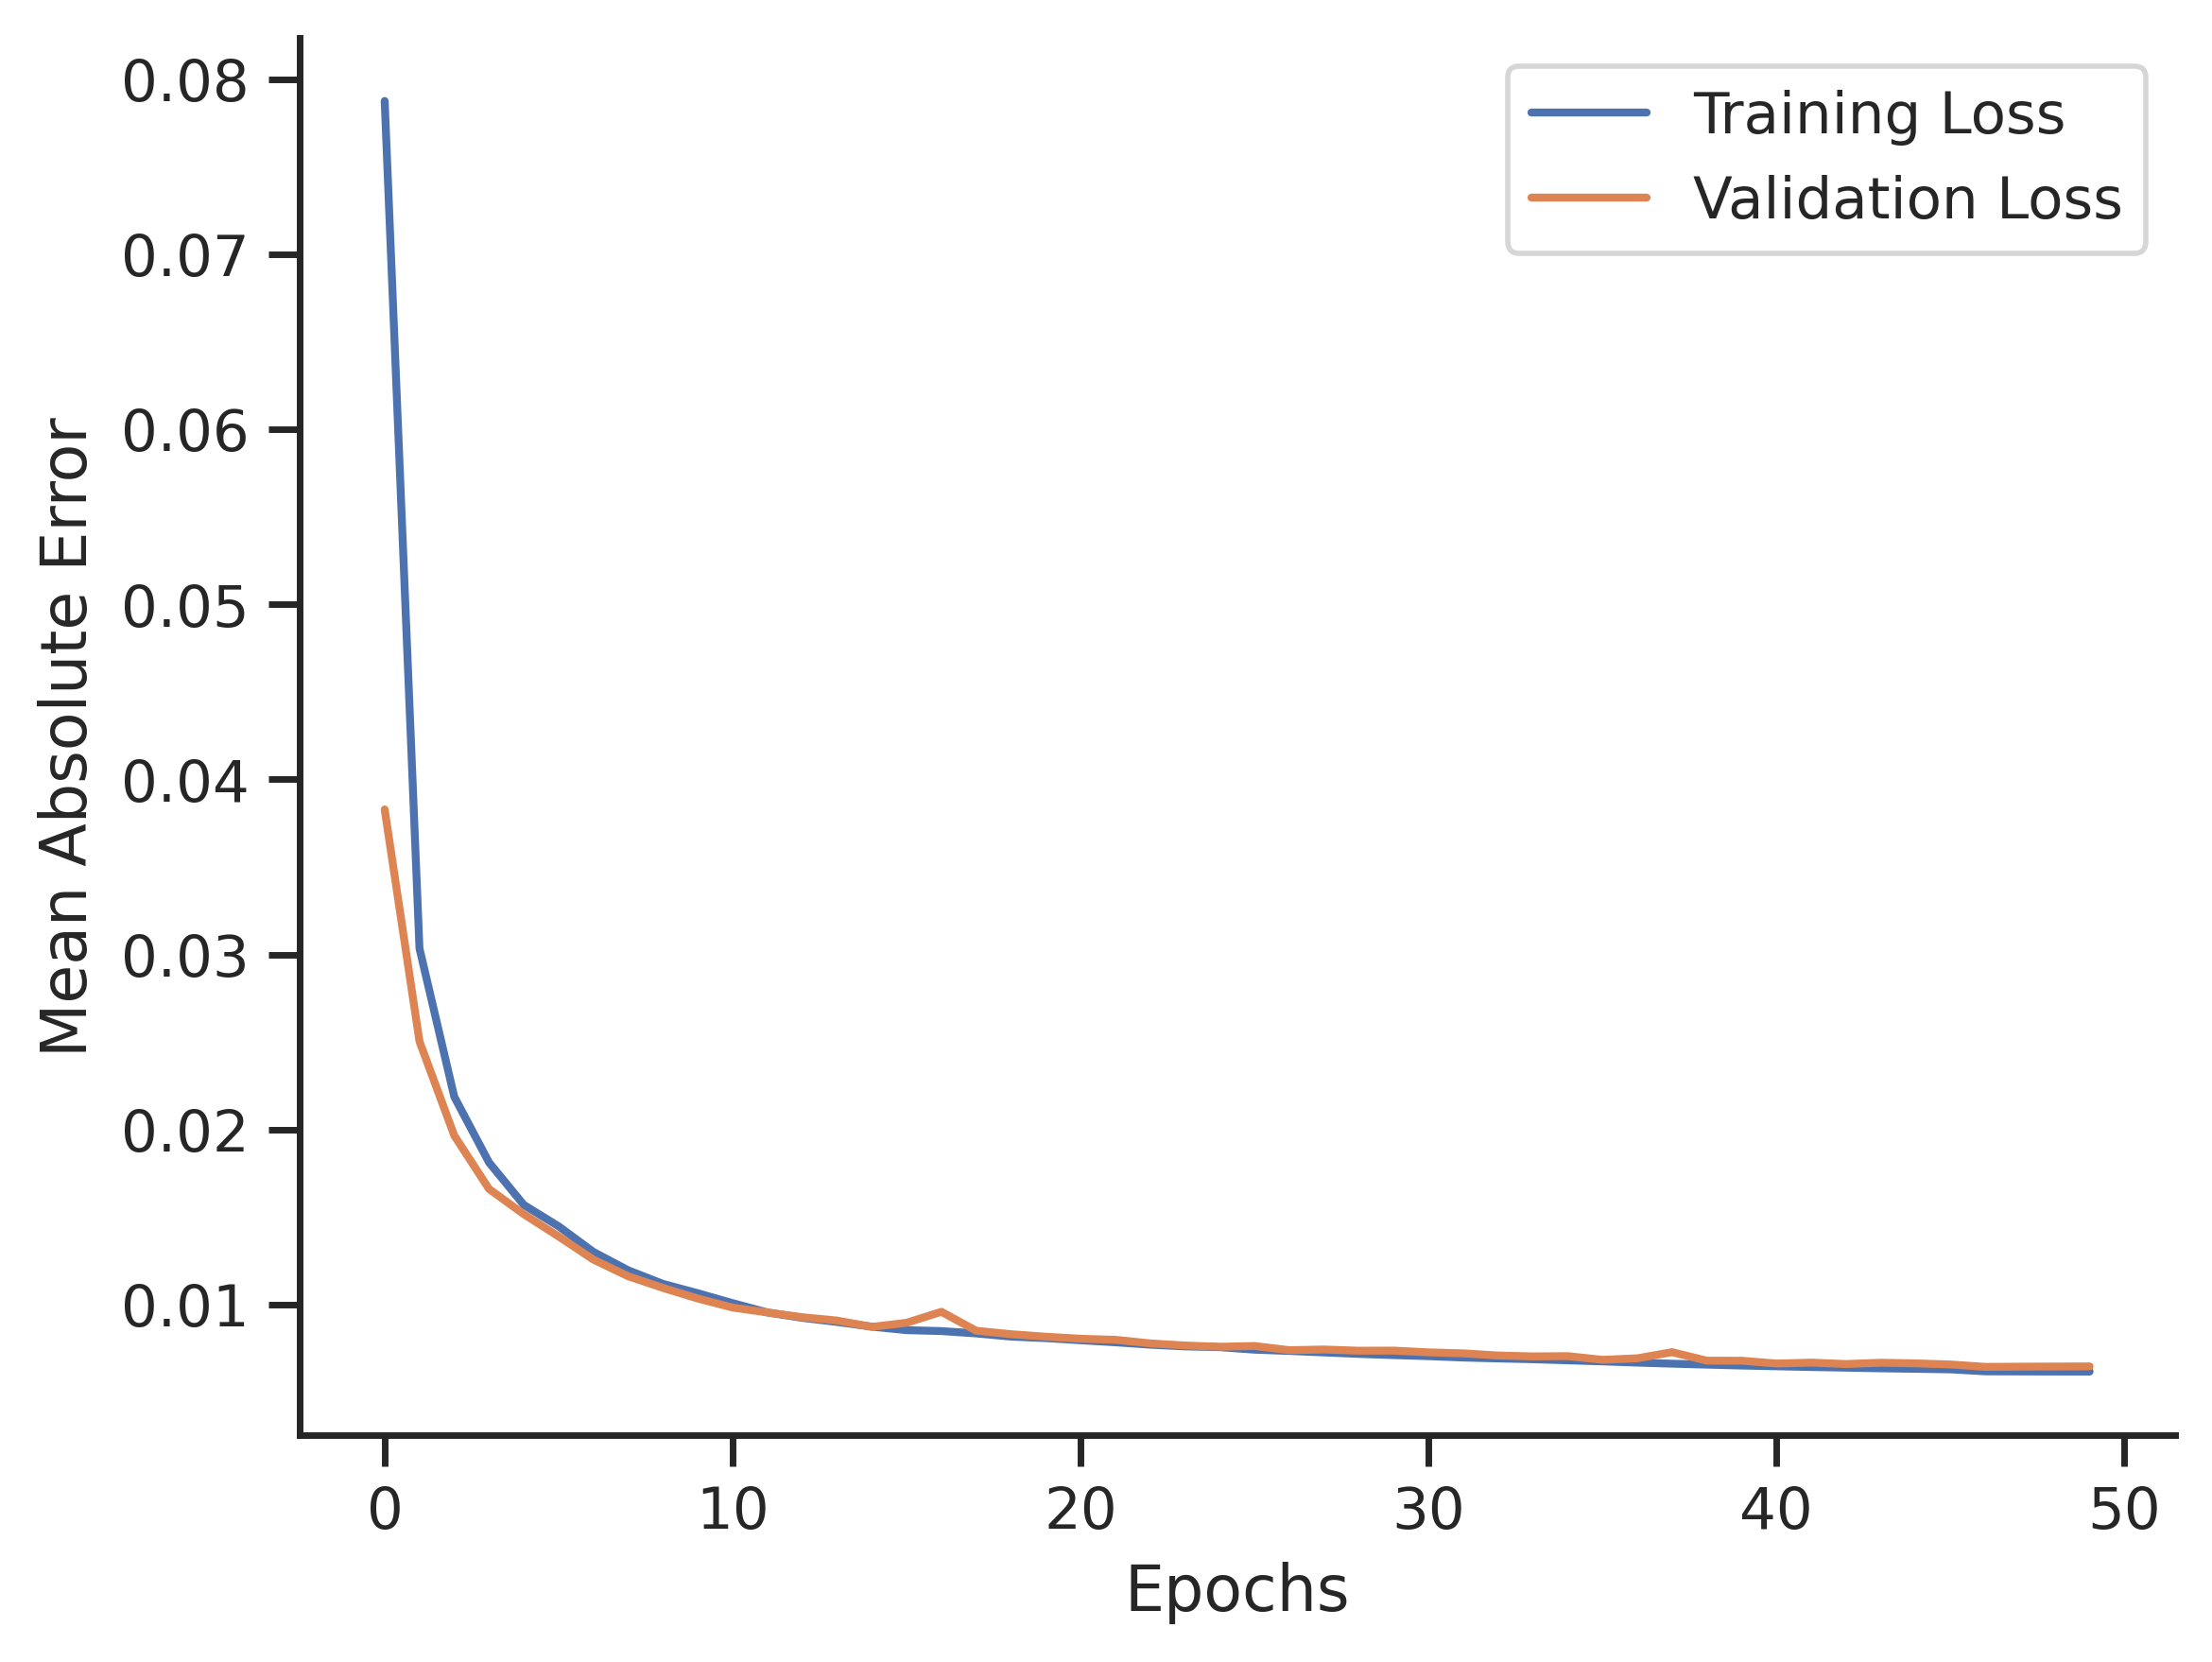

In [31]:
fig, ax = plt.subplots(dpi=400)
ax.plot(stats.history['loss'])
ax.plot(stats.history['val_loss'])
ax.legend(['Training Loss', 'Validation Loss'])
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Absolute Error")

fig.savefig("pi_loss.png")

In [32]:
preds = model.predict(X_val.iloc[:,:-2])


4314/4314 [==============================] - 2s 562us/step


(array([[ 1530.,  2639.,  4513.,  3077.,  6039., 38545., 47010.,  4574.,
         23376.,  6736.],
        [    0.,     0.,     0.,     0.,     0.,     0.,  3065., 75045.,
         59114.,   815.]]),
 array([-790.7022  , -676.90955 , -563.1169  , -449.32422 , -335.53156 ,
        -221.7389  , -107.94624 ,    5.846414,  119.63908 ,  233.43173 ,
         347.2244  ], dtype=float32),
 <a list of 2 BarContainer objects>)

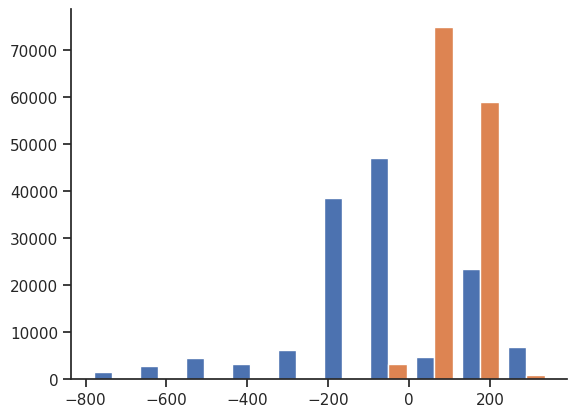

In [33]:
plt.hist(preds[1])

In [57]:
model = load_model("PI_model_new/model.h5", custom_objects={'compute_steering': compute_steering,
                                                               'compute_target_angle': compute_target_angle,
                                                               'get_max_dist_idx': get_max_dist_idx})

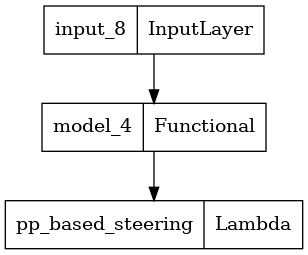

In [58]:
tf.keras.utils.plot_model(model)